In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [296]:
substation_load_df = pd.read_csv(
    "../data/french_king_8760_hourly_net_injection_2023.csv",
    names=["timestamp", "net_injection_mw"],
    parse_dates=["timestamp"],
    index_col="timestamp",
)
substation_load_df["net_load_mw"] = -substation_load_df[
    "net_injection_mw"
]  # Convert to load

solar_df = pd.read_csv(
    "../data/us_ma_franklin_2023_pv_1kwdc.csv",
    parse_dates=["timestamp"],
    index_col="timestamp",
)
solar_df.index = pd.to_datetime(solar_df.index, utc=True).tz_convert("America/New_York")
# Shift to beginning of hour
solar_df.index = solar_df.index.floor("H", ambiguous="NaT", nonexistent="shift_forward")

# Flexible interconnection
## How to get more out of the grid we already have

Traditionally, the grid is built for the highest load hour of each year.

As we add solar, we start seeing <span style="color:pink">reverse power flow</span> when solar produces more electricity than can be consumed locally.

*\*Note: net load data are for an actual Eversource substation in western Massachusetts.*

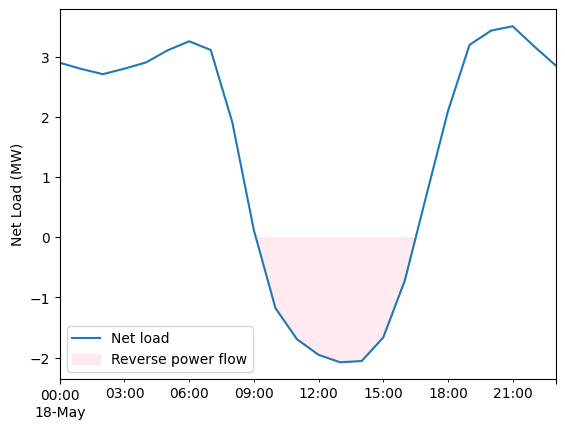

In [348]:
day_mask = substation_load_df.index.date == pd.Timestamp("2023-05-18").date()
substation_load_df.loc[day_mask].plot(
    y="net_load_mw",
    ylabel="Net Load (MW)",
    xlabel="",
    label="Net load",
)
plt.fill_between(
    substation_load_df.loc[day_mask].index,
    0,
    substation_load_df.loc[day_mask]["net_load_mw"],
    where=substation_load_df[day_mask]["net_load_mw"] <= 0,
    color="pink",
    alpha=0.3,
    interpolate=True,
    label="Reverse power flow",
)
plt.legend()

As <span style="color:pink">reverse power flow</span> approaches the <span style="color:red">thermal limit</span> of the local grid, this limits the <span style="color:blue">hosting capacity</span> of the circuit (i.e. the ability of the grid to accomodate new solar).

*(assuming a 10 MW thermal limit for illustration)*

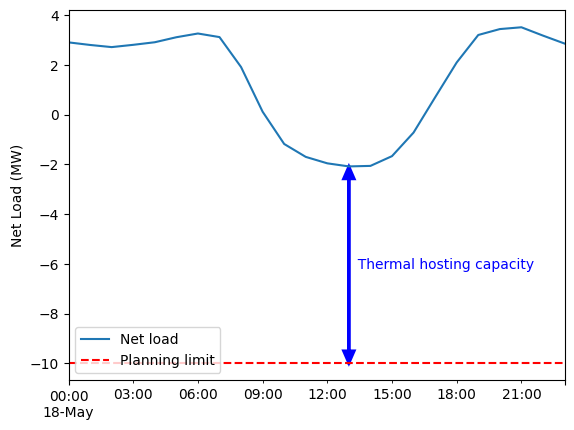

In [298]:
THERMAL_LIMIT = -10.0

day_mask = substation_load_df.index.date == pd.Timestamp("2023-05-18").date()
substation_load_df.loc[day_mask].plot(
    y="net_load_mw",
    ylabel="Net Load (MW)",
    xlabel="",
    label="Net load",
)
plt.hlines(
    THERMAL_LIMIT,
    substation_load_df.loc[day_mask].index[0],
    substation_load_df.loc[day_mask].index[-1],
    color="red",
    linestyle="--",
    label="Planning limit",
)
plt.arrow(
    pd.Timestamp("2023-05-18 13:00"),
    THERMAL_LIMIT,
    0,
    substation_load_df.loc[day_mask]["net_load_mw"].min() - THERMAL_LIMIT,
    head_width=0.5,
    head_length=0.5,
    linewidth=2,
    fc="blue",
    ec="blue",
    shape="full",
    length_includes_head=True,
)
plt.arrow(  # Repeat for double-headed arrow
    pd.Timestamp("2023-05-18 13:00"),
    substation_load_df.loc[day_mask]["net_load_mw"].min(),
    0,
    THERMAL_LIMIT - substation_load_df.loc[day_mask]["net_load_mw"].min(),
    head_width=0.5,
    head_length=0.5,
    linewidth=2,
    fc="blue",
    ec="blue",
    shape="full",
    length_includes_head=True,
)
plt.text(
    pd.Timestamp("2023-05-18 13:30"),
    (THERMAL_LIMIT + substation_load_df.loc[day_mask]["net_load_mw"].min()) / 2,
    "  Thermal hosting capacity",
    color="blue",
    fontsize=10,
    va="center",
)

plt.legend()

However, <span style="color:blue">hosting capacity</span> is not static; it varies from day to day based on weather, load, and other grid conditions

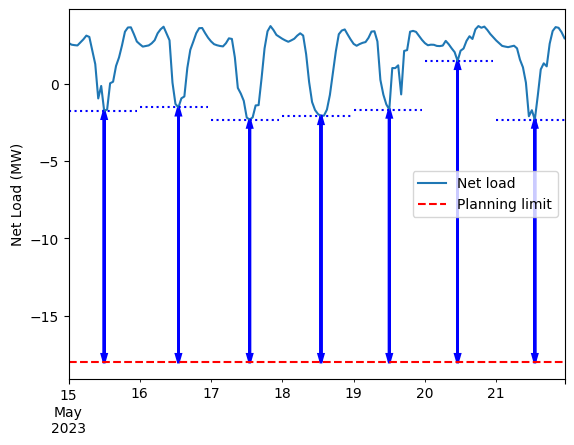

In [299]:
THERMAL_LIMIT = -18.0

days_mask = (substation_load_df.index.date >= pd.Timestamp("2023-05-15").date()) & (
    substation_load_df.index.date <= pd.Timestamp("2023-05-21").date()
)
substation_load_df.loc[days_mask].plot(
    y="net_load_mw",
    ylabel="Net Load (MW)",
    xlabel="",
    label="Net load",
)
plt.hlines(
    THERMAL_LIMIT,
    substation_load_df.loc[days_mask].index[0],
    substation_load_df.loc[days_mask].index[-1],
    color="red",
    linestyle="--",
    label="Planning limit",
)

for day in pd.date_range("2023-05-15", "2023-05-21"):
    day_min_time = substation_load_df.loc[substation_load_df.index.date == day.date()][
        "net_load_mw"
    ].idxmin()
    day_min_load = substation_load_df.loc[substation_load_df.index.date == day.date()][
        "net_load_mw"
    ].min()

    plt.hlines(
        day_min_load,
        day,
        day + pd.Timedelta(hours=23, minutes=59),
        color="blue",
        linestyle=":",
        linewidth=1.5,
    )
    plt.arrow(
        day_min_time,
        THERMAL_LIMIT,
        0,
        substation_load_df.loc[substation_load_df.index.date == day.date()][
            "net_load_mw"
        ].min()
        - THERMAL_LIMIT,
        head_width=1.5,
        head_length=0.5,
        linewidth=2,
        fc="blue",
        ec="blue",
        shape="full",
        length_includes_head=True,
    )
    plt.arrow(  # Repeat for double-headed arrow
        day_min_time,
        substation_load_df.loc[substation_load_df.index.date == day.date()][
            "net_load_mw"
        ].min(),
        0,
        THERMAL_LIMIT
        - substation_load_df.loc[substation_load_df.index.date == day.date()][
            "net_load_mw"
        ].min(),
        head_width=1.5,
        head_length=0.5,
        linewidth=2,
        fc="blue",
        ec="blue",
        shape="full",
        length_includes_head=True,
    )

plt.legend()

Traditional interconnection limits solar based on the worst hour of the year, requiring expensive grid upgrades to build more.

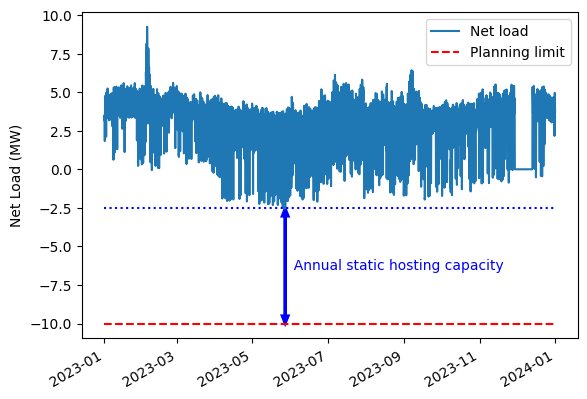

In [300]:
THERMAL_LIMIT = -10.0

substation_load_df.plot(
    y="net_load_mw",
    ylabel="Net Load (MW)",
    xlabel="",
    label="Net load",
)
plt.hlines(
    THERMAL_LIMIT,
    substation_load_df.index[0],
    substation_load_df.index[-1],
    color="red",
    linestyle="--",
    label="Planning limit",
)

min_load_overall_time = substation_load_df["net_load_mw"].idxmin()
min_load_overall = substation_load_df["net_load_mw"].min()

plt.hlines(
    min_load_overall,
    substation_load_df.index[0],
    substation_load_df.index[-1],
    color="blue",
    linestyle=":",
    linewidth=1.5,
)
plt.arrow(
    min_load_overall_time,
    THERMAL_LIMIT,
    0,
    min_load_overall - THERMAL_LIMIT,
    head_width=5,
    head_length=0.5,
    linewidth=2,
    fc="blue",
    ec="blue",
    shape="full",
    length_includes_head=True,
)
plt.arrow(  # Repeat for double-headed arrow
    min_load_overall_time,
    min_load_overall,
    0,
    THERMAL_LIMIT - substation_load_df["net_load_mw"].min(),
    head_width=5,
    head_length=0.5,
    linewidth=2,
    fc="blue",
    ec="blue",
    shape="full",
    length_includes_head=True,
)
plt.text(
    min_load_overall_time + pd.Timedelta(minutes=30),
    (THERMAL_LIMIT + min_load_overall) / 2,
    "  Annual static hosting capacity",
    color="blue",
    fontsize=10,
    va="center",
)

plt.legend()

Even though most days don't come close to the limit, planning for the most-constrained hour severely limits the amount of solar that can be installed.

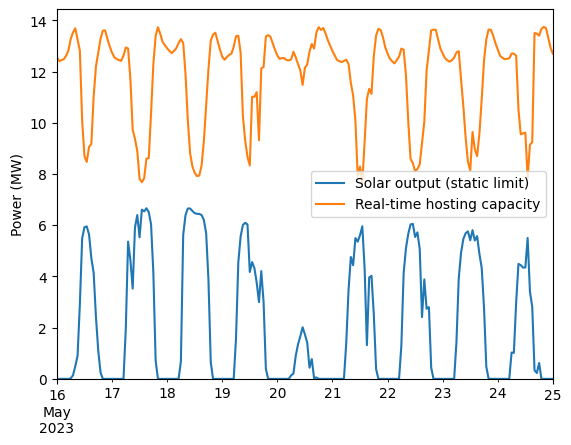

In [321]:
THERMAL_LIMIT = -10.0

real_time_hosting_capacity = substation_load_df["net_load_mw"] - THERMAL_LIMIT
real_time_hosting_capacity.index = real_time_hosting_capacity.index.tz_localize("America/New_York", ambiguous=True)
solar_and_hc_df = pd.merge(
    solar_df,
    real_time_hosting_capacity.rename("real_time_hosting_capacity"),
    left_index=True,
    right_index=True,
)

solar_days_mask = (
    (solar_and_hc_df.index >= "2023-05-16") &
    (solar_and_hc_df.index <= "2023-05-25")
)
constrained_solar_size = real_time_hosting_capacity.min()
solar_and_hc_df["ac_output_static"] = solar_and_hc_df["ac_kw_per_kwdc"] * constrained_solar_size

solar_and_hc_df[solar_days_mask].plot(
    y=["ac_output_static", "real_time_hosting_capacity"],
    label=["Solar output (static limit)", "Real-time hosting capacity"],
    ylabel="Power (MW)",
    xlabel="",
)

plt.ylim(bottom=0)

plt.legend()

**Flexible interconnection** allows solar to use the precise amount of hosting capacity available in real time, turning down (<span style="background-color: #99d2f7; color: #003366;">curtailing</span>) when the grid is congested.

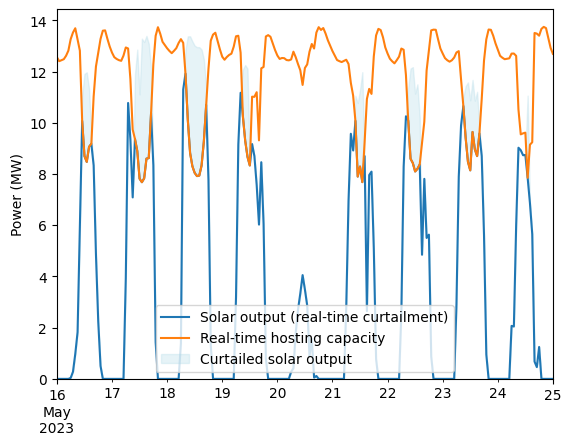

In [325]:
THERMAL_LIMIT = -10.0

real_time_hosting_capacity = substation_load_df["net_load_mw"] - THERMAL_LIMIT
real_time_hosting_capacity.index = real_time_hosting_capacity.index.tz_localize("America/New_York", ambiguous=True)
solar_and_hc_df = pd.merge(
    solar_df,
    real_time_hosting_capacity.rename("real_time_hosting_capacity"),
    left_index=True,
    right_index=True,
)

solar_days_mask = (
    (solar_and_hc_df.index >= "2023-05-16") &
    (solar_and_hc_df.index <= "2023-05-25")
)
SOLAR_SIZE_DC = 15  # MW
solar_and_hc_df["ac_output_raw"] = solar_and_hc_df["ac_kw_per_kwdc"] * SOLAR_SIZE_DC
solar_and_hc_df["ac_output_fi"] = solar_and_hc_df["ac_output_raw"].clip(upper=solar_and_hc_df["real_time_hosting_capacity"])

solar_and_hc_df[solar_days_mask].plot(
    y=["ac_output_fi", "real_time_hosting_capacity"],
    xlabel="",
    label=["Solar output (real-time curtailment)", "Real-time hosting capacity"],
    ylabel="Power (MW)"
)
plt.fill_between(
    solar_and_hc_df[solar_days_mask].index,
    solar_and_hc_df.loc[solar_days_mask]["ac_output_fi"],
    solar_and_hc_df.loc[solar_days_mask]["ac_output_raw"],
    color="lightblue",
    alpha=0.3,
    label="Curtailed solar output",
    interpolate=True,
)

plt.ylim(bottom=0)

plt.legend()

Over the course of the year, the real-time hosting capacity can be much larger than the static capacity.

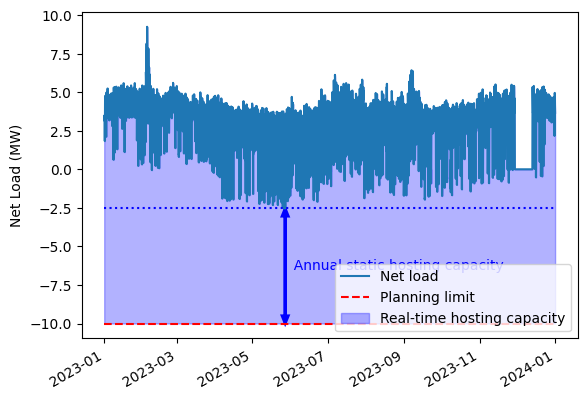

In [302]:
THERMAL_LIMIT = -10.0

substation_load_df.plot(
    y="net_load_mw",
    ylabel="Net Load (MW)",
    xlabel="",
    label="Net load",
)
plt.hlines(
    THERMAL_LIMIT,
    substation_load_df.index[0],
    substation_load_df.index[-1],
    color="red",
    linestyle="--",
    label="Planning limit",
)

plt.fill_between(
    substation_load_df.index,
    THERMAL_LIMIT,
    substation_load_df["net_load_mw"],
    color="blue",
    alpha=0.3,
    interpolate=True,
    label="Real-time hosting capacity",
)

min_load_overall_time = substation_load_df["net_load_mw"].idxmin()
min_load_overall = substation_load_df["net_load_mw"].min()

plt.hlines(
    min_load_overall,
    substation_load_df.index[0],
    substation_load_df.index[-1],
    color="blue",
    linestyle=":",
    linewidth=1.5,
)
plt.arrow(
    min_load_overall_time,
    THERMAL_LIMIT,
    0,
    min_load_overall - THERMAL_LIMIT,
    head_width=5,
    head_length=0.5,
    linewidth=2,
    fc="blue",
    ec="blue",
    shape="full",
    length_includes_head=True,
)
plt.arrow(  # Repeat for double-headed arrow
    min_load_overall_time,
    min_load_overall,
    0,
    THERMAL_LIMIT - substation_load_df["net_load_mw"].min(),
    head_width=5,
    head_length=0.5,
    linewidth=2,
    fc="blue",
    ec="blue",
    shape="full",
    length_includes_head=True,
)
plt.text(
    min_load_overall_time + pd.Timedelta(minutes=30),
    (THERMAL_LIMIT + min_load_overall) / 2,
    "  Annual static hosting capacity",
    color="blue",
    fontsize=10,
    va="center",
)

plt.legend()

Over the course of the year, flexible interconnection allows solar to generate much more electricity without overloading the grid. Only a small fraction of the solar production ends up getting thrown away (curtailed), even when we have twice as much solar installed as the static hosting capacity would allow!

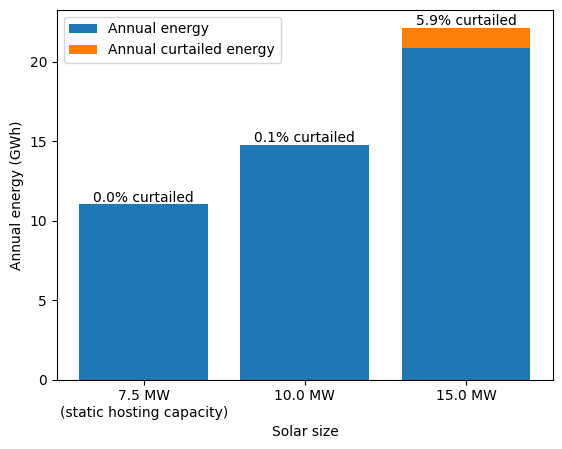

In [343]:
THERMAL_LIMIT = -10.0

real_time_hosting_capacity = substation_load_df["net_load_mw"] - THERMAL_LIMIT
real_time_hosting_capacity.index = real_time_hosting_capacity.index.tz_localize("America/New_York", ambiguous=True)
solar_and_hc_df = pd.merge(
    solar_df,
    real_time_hosting_capacity.rename("real_time_hosting_capacity"),
    left_index=True,
    right_index=True,
)

solar_days_mask = (
    (solar_and_hc_df.index >= "2023-05-16") &
    (solar_and_hc_df.index <= "2023-05-25")
)
sizes = [real_time_hosting_capacity.min(), 10, 15]
annual_mwh = []
annual_curtailed_mwh = []
for size in sizes:
    solar_and_hc_df["ac_output_raw"] = solar_and_hc_df["ac_kw_per_kwdc"] * size
    solar_and_hc_df["ac_output_fi"] = solar_and_hc_df["ac_output_raw"].clip(upper=solar_and_hc_df["real_time_hosting_capacity"])
    solar_and_hc_df["ac_output_curtailed"] = solar_and_hc_df["ac_output_raw"] - solar_and_hc_df["ac_output_fi"]
    annual_mwh.append(solar_and_hc_df["ac_output_fi"].sum())
    annual_curtailed_mwh.append(solar_and_hc_df["ac_output_curtailed"].sum())

annual_gwh = np.array(annual_mwh) / 1000
curtailed_gwh = np.array(annual_curtailed_mwh) / 1000
sizes_cat = [f"{s:.1f} MW" for s in sizes]
sizes_cat[0] += "\n(static hosting capacity)"

plt.bar(
    sizes_cat,
    annual_gwh,
    label="Annual energy",
)

plt.bar(
    sizes_cat,
    curtailed_gwh,
    bottom=annual_gwh,
    label="Annual curtailed energy",
)

total_gwh = annual_gwh + curtailed_gwh
pct_curt = np.where(
    total_gwh > 0,
    100 * curtailed_gwh / total_gwh,
    0,
)

for x, y, p in zip(sizes_cat, total_gwh, pct_curt):
    plt.text(
        x,
        y,
        f"{p:.1f}% curtailed",
        ha="center",
        va="bottom",
    )

plt.ylabel("Annual energy (GWh)")
plt.xlabel("Solar size")
plt.ylim(bottom=0)
plt.legend()
